### Setup

If you want to write your own code and not follow this format, it is ok. Just make sure to use the same hyperparameters and models. If you see convergence sooner during the training, you may use fewer iterations.

In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

# Latent dimensions
z = 10
# Training iterations
iter_max = 200
# Batch size
batch_size = 1000
# For the optimizers
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [2]:
def get_mnist_data(device, batch_size, validation_split=0.1):
    preprocess = transforms.ToTensor()

    # Load the entire MNIST dataset
    full_dataset = datasets.MNIST('data', train=True, download=True, transform=preprocess)

    # Calculate the number of validation samples based on the split
    num_train = len(full_dataset)
    num_val = int(validation_split * num_train)
    num_train = num_train - num_val

    # Split the dataset into training and validation sets
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [num_train, num_val])

    # Create data loaders for training and validation
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True)

    # Create pre-processed training and validation sets
    X_train = train_loader.dataset.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.dataset.train_labels.to(device)
    X_val = val_loader.dataset.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_val = val_loader.dataset.dataset.train_labels.to(device)

    return train_loader, val_loader, (X_val, y_val)

train_loader, val_loader, _ = get_mnist_data(device, batch_size, validation_split=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


### Utility Functions
- Complete the code for the function ```sample_gaussian```

In [3]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    ################################################################################
    # TODO: complete the code here
    # Task: Sample z


    #z = torch.distributions.normal.Normal(m,torch.sqrt(v)).rsample()
    epsilon = torch.randn_like(v)
    z = m + torch.sqrt(v) * epsilon


    # End
    ################################################################################

    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

def duplicate(x, rep):
    """
    Duplicates x along dim=0

    Args:
        x: tensor: (batch, ...): Arbitrary tensor
        rep: int: (): Number of replicates. Setting rep=1 returns orignal x

    Returns:
        _: tensor: (batch * rep, ...): Arbitrary replicated tensor
    """
    return x.expand(rep, *x.shape).reshape(-1, *x.shape[1:])

def log_normal(x, m, v):
    """
    Computes the elem-wise log probability of a Gaussian and then sum over the
    last dim. Basically we're assuming all dims are batch dims except for the
    last dim.

    Args:
        x: tensor: (batch_1, batch_2, ..., batch_k, dim): Observation
        m: tensor: (batch_1, batch_2, ..., batch_k, dim): Mean
        v: tensor: (batch_1, batch_2, ..., batch_k, dim): Variance

    Return:
        log_prob: tensor: (batch_1, batch_2, ..., batch_k): log probability of
            each sample. Note that the summation dimension is not kept
    """
    log_std = torch.log(torch.sqrt(v))
    log_probs = -((x - m) ** 2) / (2 * v) - log_std - np.log(np.sqrt(2 * np.pi))
    log_prob = log_probs.sum(-1)

    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob

def log_mean_exp(x, dim):
    """
    Compute the log(mean(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which mean is computed

    Return:
        _: tensor: (...): log(mean(exp(x), dim))
    """
    return log_sum_exp(x, dim) - np.log(x.size(dim))

def log_sum_exp(x, dim=0):
    """
    Compute the log(sum(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which sum is computed

    Return:
        _: tensor: (...): log(sum(exp(x), dim))
    """
    max_x = torch.max(x, dim)[0]
    new_x = x - max_x.unsqueeze(dim).expand_as(x)
    return max_x + (new_x.exp().sum(dim)).log()

### Base Models

In [4]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

- Complete the functions ```negative_elbo_bound``` and ```negative_iwae_bound```. Make sure to use functions provided in the ***Utility*** and ***Base Model*** sections for your benefit when completing the code.

In [5]:
class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim

        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: complete the code here
        # Task: Compute negative Evidence Lower Bound and its KL and Reconstruction term
        # Note that nelbo = kl + rec
        # Outputs should all be scalar


        # Encode x to get the mean and variance of the latent variable
        qm, qv = self.enc.encode(x)

        # Sample z from the approximate posterior
        z = sample_gaussian(qm, qv)

        # Decode z to get the reconstruction
        x_recon = self.dec.decode(z)

        # Compute the reconstruction loss
        rec = -1 * log_bernoulli_with_logits(x, x_recon)

        # Compute the KL divergence
        kl = kl_normal(qm, qv, self.z_prior_m, self.z_prior_v)

        # Compute the negative ELBO
        nelbo = kl + rec

        return nelbo.mean(), kl.mean(), rec.mean()


        # End
        ################################################################################

        # return nelbo, kl, rec

    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: Modify/complete the code here
        # Compute niwae (negative IWAE) with iw importance samples, and the KL
        # and Rec decomposition of the Evidence Lower Bound
        #
        # Outputs should all be scalar
        ################################################################################


        qm, qv = self.enc.encode(x)
        qm = duplicate(qm, iw)
        qv = duplicate(qv, iw)
        x = duplicate(x, iw)

        z = sample_gaussian(qm,qv)

        probs = self.dec.decode(z)

        rec = -1 * log_bernoulli_with_logits( x,probs)
        kl = log_normal(z,qm,qv) -  log_normal(z, self.z_prior_m[0], self.z_prior_v[0])
        nelbo = kl + rec

        niwae = -1 * log_mean_exp(-nelbo.reshape(iw,-1), dim=0)




        ################################################################################
        # End of code modification
        ################################################################################
        return niwae.mean(), kl.mean(), rec.mean()


    def loss(self, x):
        nelbo, kl, rec = self.negative_elbo_bound(x)
        loss = nelbo

        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))

        return loss, summaries

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


### Run model

- You will probably need to add some lines to this code. (Add test set, save statistics and plot, ...)

Note that Negative ELBO on the test set should be around 100.

100%|██████████| 200/200 [21:22<00:00,  6.41s/it]


Training Completed!


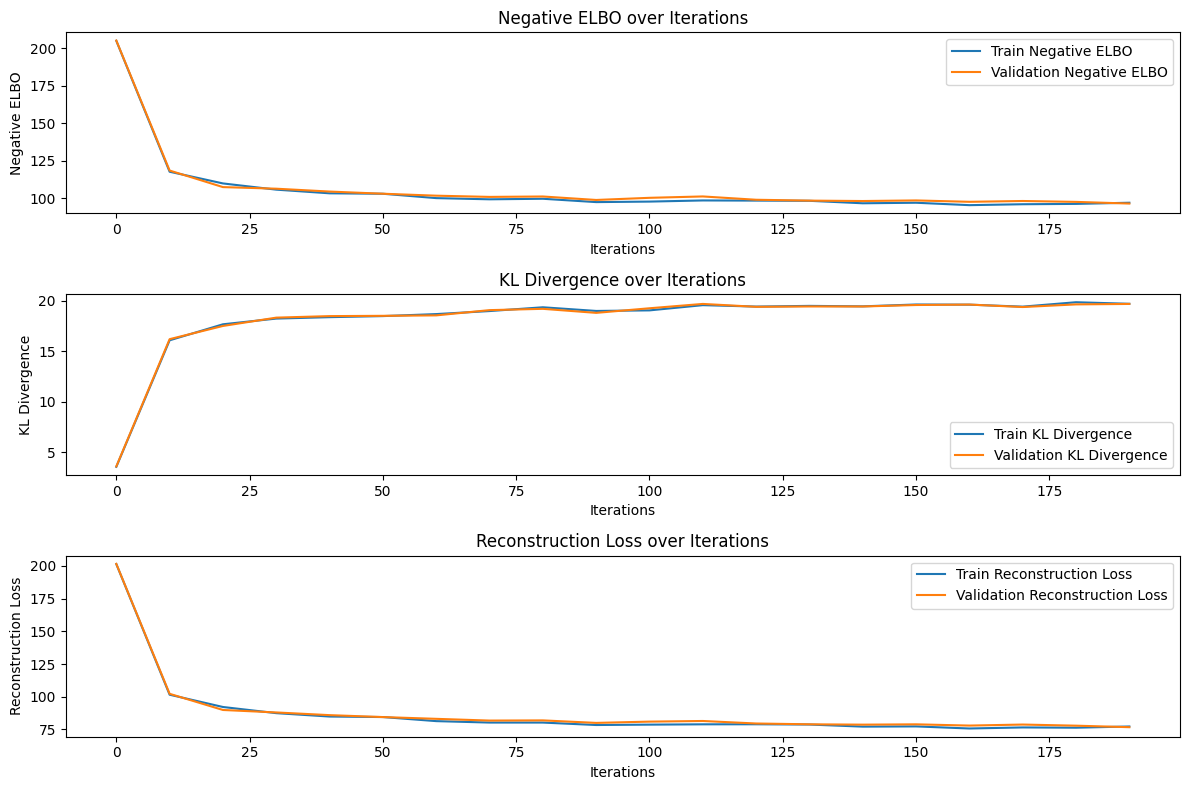

In [6]:

# vae = VAE(z_dim=z).to(device)
# optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# for i in tqdm(range(iter_max)):
#     for batch_idx, (xu, yu) in enumerate(train_loader):

#         optimizer.zero_grad()

#         xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
#         yu = yu.new(np.eye(10)[yu]).to(device).float()
#         loss, summaries = vae.loss(xu)

#         loss.backward()
#         optimizer.step()

#     print(summaries['train/loss'])

#     ################################################################################
#     # TODO: complete the code here
#     # report the loss terms across time for train and validation datasets
#     #
#     # You can choose to only perform validation once in every 10 (Or any other number
#     # depending on the speed of the algorithm on your machine) iterations and display
#     # the training and validation statistics on those iterataions.

#     # Report the loss terms across time for train and validation datasets
#     # End
#     ################################################################################


import matplotlib.pyplot as plt

vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Lists to store the loss terms during training and validation
train_losses = []
train_kls = []
train_recs = []
val_losses = []
val_kls = []
val_recs = []

for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae.loss(xu)

        loss.backward()
        optimizer.step()

    #print(summaries['train/loss'])

    # Report the loss terms across time for train and validation datasets
    if i % 10 == 0:
        # Training dataset
        train_loss, train_kl, train_rec = vae.negative_elbo_bound(xu)
        train_losses.append(train_loss.item())
        train_kls.append(train_kl.item())
        train_recs.append(train_rec.item())

        # Validation dataset (assuming you have a validation loader named 'val_loader')
        for batch_idx, (xv, yv) in enumerate(val_loader):
            xv = torch.bernoulli(xv.to(device).reshape(xv.size(0), -1))
            yv = yv.new(np.eye(10)[yv]).to(device).float()
            val_loss, val_kl, val_rec = vae.negative_elbo_bound(xv)

        val_losses.append(val_loss.item())
        val_kls.append(val_kl.item())
        val_recs.append(val_rec.item())

print("Training Completed!")

# Plotting the loss terms over iterations
iterations = range(0, iter_max, 10)

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(iterations, train_losses, label='Train Negative ELBO')
plt.plot(iterations, val_losses, label='Validation Negative ELBO')
plt.title('Negative ELBO over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Negative ELBO')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(iterations, train_kls, label='Train KL Divergence')
plt.plot(iterations, val_kls, label='Validation KL Divergence')
plt.title('KL Divergence over Iterations')
plt.xlabel('Iterations')
plt.ylabel('KL Divergence')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(iterations, train_recs, label='Train Reconstruction Loss')
plt.plot(iterations, val_recs, label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Reconstruction Loss')
plt.legend()

plt.tight_layout()
# plt.savefig("loss.pdf")
plt.show()


In [7]:
torch.save(vae, 'vae_model.pth')

In [8]:
import torch

# Load the trained VAE model
vae = torch.load('vae_model.pth').to(device)

# Values of m to evaluate
m_values = [5, 50, 150]

# Store the results
results = {'m': [], 'niwae_avg': [], 'elbo_avg': []}

for m in m_values:
    niwae_vals = []
    elbo_vals = []

    for _ in tqdm(range(50)):  # 50 repetitions
        for xv, _ in val_loader:
            xv = torch.bernoulli(xv.to(device).reshape(xv.size(0), -1))

            # Compute negative IWAE
            niwae, _, _ = vae.negative_iwae_bound(xv, m)
            niwae_vals.append(niwae.item())

            # Compute negative ELBO
            elbo, _, _ = vae.negative_elbo_bound(xv)
            elbo_vals.append(elbo.item())

    # Average the results
    results['m'].append(m)
    results['niwae_avg'].append(sum(niwae_vals) / len(niwae_vals))
    results['elbo_avg'].append(sum(elbo_vals) / len(elbo_vals))

# Report the results
print("Results:")
for m, niwae_avg, elbo_avg in zip(results['m'], results['niwae_avg'], results['elbo_avg']):
    print(f"m = {m}: Average Negative IWAE = {niwae_avg}, Average Negative ELBO = {elbo_avg}")


100%|██████████| 50/50 [01:03<00:00,  1.26s/it]

Results:
m = 5: Average Negative IWAE = 95.54060094197591, Average Negative ELBO = 97.33104011535644
m = 50: Average Negative IWAE = 94.50123512268067, Average Negative ELBO = 97.35990272521973
m = 150: Average Negative IWAE = 94.220611038208, Average Negative ELBO = 97.33820798238118
